# Cube in a Box

### Basic Functionality



This notebook introduces the following concepts:
 - The Datacube module
 - Loading Data
 - Visualising Data
 - Filtering out cloud and occluded land pixels
 - Visualising nDVI trough time.

In [ ]:
%matplotlib inline
%%pep8

import datacube # Load the datacube library
import datetime
import numpy as np
import json
from utils.utils import (
    lat_lon_to_epsg,
    three_band_image,
    load_config_extents,
    transform_to_wgs)

In [ ]:
# Load the extent parameters used to index data cube in the box data.
extents, bbox = load_config_extents('/opt/odc/data/configIndex.txt')

lon_min,lon_max,lat_min,lat_max = extents
EPSG = lat_lon_to_epsg(lat_max,lon_min)

In [ ]:
#Creating an instance of the datacube.
dc = datacube.Datacube(app='dc-visualize')

In the sample below we use the datacube.load command to load the RGB and Quality Assurance(QA) bands from the AWS Landsat archive. Landsat 8 has a return period of 16 days capturing over 24 snapshots a year so care should be taken when requesting a datacube as large geographical or time extents can quickly over fill memory and generate huge lag. 

For our first visualisation we'll load a single time slice of the full geographical extent indexed and then proceed to select a smaller zone to explore through time.

It should be noted that images on AWS are referenced to WGS 84 so the extent bounds that are entered into the datacube.load() must match the coordinate system in which they're being stored. 

The datacube.load() command also reprojects into a coordinate system in the below datacube load we automatically generate an EPSG code from the lat/long of the provided extent. 

If you'd like to visualize other bands add any of the below measurements to the `datacube.load(measurements= ...`:

Landsat 8 measurement options are:

             ('1', 'coastal_aerosol')
             ('2', 'blue')
             ('3', 'green')
             ('4', 'red')
             ('5', 'nir')
             ('6', 'swir1')
             ('7', 'swir2')
             ('8', 'panchromatic')
             ('9', 'cirrus')
             ('10', 'lwir1')
             ('11', 'lwir2')
             ('QUALITY', 'quality')]


In [ ]:
%%time

date_range = (
    datetime.datetime(2017, 3, 12),
    datetime.datetime(2017, 3, 14)) 
ds = dc.load(
    product='ls8_level1_usgs',
    x=(lon_min, lon_max),
    y=(lat_min, lat_max), 
    output_crs='epsg:' + EPSG,
    resolution=(-30, 30),
    time = date_range, 
    measurements = ('red','green','blue','quality'))

The `datacube.load()` command returns an [xarray](https://xarray.pydata.org/en/stable/). The key to building effective ODC algorithms is to master the use of the xarray. Please click on the documention to find out more otherwise a number of examples are provided below.

The xarray for landsat contains the dimensions of X, Y and Time - for each combination of these dimensions data listed as "Data Variables" can be retrieved. 

In [13]:
print(ds) # Viewing data

<xarray.Dataset>
Dimensions:  (time: 1, x: 1439, y: 1267)
Coordinates:
  * time     (time) datetime64[ns] 2017-03-12T23:52:26.445797
  * y        (y) float64 5.217e+06 5.217e+06 5.217e+06 5.217e+06 5.217e+06 ...
  * x        (x) float64 4.431e+05 4.431e+05 4.432e+05 4.432e+05 4.432e+05 ...
Data variables:
    red      (time, y, x) int16 15800 14191 12983 11002 10106 10130 9190 ...
    green    (time, y, x) int16 15415 13831 12980 11105 10315 10151 9334 ...
    blue     (time, y, x) int16 15732 14344 13446 11655 11022 10969 10156 ...
    quality  (time, y, x) int16 2800 2800 2800 2800 2800 2800 2800 2800 2800 ...
Attributes:
    crs:      epsg:32755


In [14]:
# Query xarray using index 0 will retrieve the first record of each dimension
print (ds.isel(time=[0], x=[0], y=[0])) 


<xarray.Dataset>
Dimensions:  (time: 1, x: 1, y: 1)
Coordinates:
  * time     (time) datetime64[ns] 2017-03-12T23:52:26.445797
  * y        (y) float64 5.217e+06
  * x        (x) float64 4.431e+05
Data variables:
    red      (time, y, x) int16 15800
    green    (time, y, x) int16 15415
    blue     (time, y, x) int16 15732
    quality  (time, y, x) int16 2800
Attributes:
    crs:      epsg:32755


<xarray.Dataset>
Dimensions:  (time: 1, x: 1, y: 1267)
Coordinates:
  * time     (time) datetime64[ns] 2017-03-12T23:52:26.445797
  * y        (y) float64 5.217e+06 5.217e+06 5.217e+06 5.217e+06 5.217e+06 ...
  * x        (x) float64 4.431e+05
Data variables:
    red      (time, y, x) int16 15800 16249 14122 10829 10021 9575 8719 7925 ...
    green    (time, y, x) int16 15415 15472 14041 10815 10067 9728 8981 8228 ...
    blue     (time, y, x) int16 15732 16105 14661 11468 10937 10549 9758 ...
    quality  (time, y, x) int16 2800 2800 2800 2800 2800 2800 2800 2800 2976 ...
Attributes:
    crs:      epsg:32755


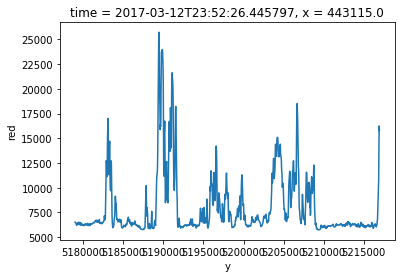

In [15]:
# To extract a cross-section of y measurements between from the first.
cross_section = ds.sel(x=[1], method='nearest')

print(cross_section) 
cross_section.red.plot() # Plotting the measurements from the red band.


Next we'll explore [Landsat 8 quality band](https://landsat.usgs.gov/collectionqualityband), each pixel in the QA band contains unsigned integers that represent bit-packed combinations of surface, atmospheric, and sensor conditions that can affect the overall usefulness of a given pixel.

Used effectively, QA bits improve the integrity of science investigations by indicating which pixels might be affected by instrument artifacts or subject to cloud contamination. The ODC has in built methods that transform the metadata of a specific product to a libary of masking templates. For example, you are able to build a cloud mask directly from the ODC library.

In [17]:
from datacube.storage import masking  # Import masking capabilities
print (masking.describe_variable_flags(ds)) #D escribe the masks available



                            bits  \
cirrus_confidence       [11, 12]   
cloud                        [4]   
cloud_confidence          [5, 6]   
cloud_shadow_conf         [7, 8]   
designated_fill              [0]   
radiometric_saturation    [2, 3]   
snow_ice_conf            [9, 10]   
terrain_occlusion            [1]   

                                                                   values  \
cirrus_confidence       {'0': 'Not Determined', '1': 'Low', '2': 'Medi...   
cloud                                             {'0': False, '1': True}   
cloud_confidence        {'0': 'Not Determined', '1': 'Low', '2': 'Medi...   
cloud_shadow_conf       {'0': 'Not Determined', '1': 'Low', '2': 'Medi...   
designated_fill                                   {'0': False, '1': True}   
radiometric_saturation  {'0': 'none', '1': '1-2', '2': '3-4', '3': '<=5'}   
snow_ice_conf           {'0': 'Not Determined', '1': 'Low', '2': 'Medi...   
terrain_occlusion                                 {'0': Fal

In [18]:
# Create mask around all pixels deemed good according to parameters around cloud cover and saturation.
clean_pixel_mask = masking.make_mask(
    ds.quality,
    cloud=False,
    radiometric_saturation='none',
    terrain_occlusion = False)

print(clean_pixel_mask)

masked_cloud = ds.where(clean_pixel_mask)

print(masked_cloud)

<xarray.DataArray 'quality' (time: 1, y: 1267, x: 1439)>
array([[[False, False, ...,  True,  True],
        [False, False, ...,  True,  True],
        ...,
        [ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True]]])
Coordinates:
  * time     (time) datetime64[ns] 2017-03-12T23:52:26.445797
  * y        (y) float64 5.217e+06 5.217e+06 5.217e+06 5.217e+06 5.217e+06 ...
  * x        (x) float64 4.431e+05 4.431e+05 4.432e+05 4.432e+05 4.432e+05 ...
<xarray.Dataset>
Dimensions:  (time: 1, x: 1439, y: 1267)
Coordinates:
  * time     (time) datetime64[ns] 2017-03-12T23:52:26.445797
  * y        (y) float64 5.217e+06 5.217e+06 5.217e+06 5.217e+06 5.217e+06 ...
  * x        (x) float64 4.431e+05 4.431e+05 4.432e+05 4.432e+05 4.432e+05 ...
Data variables:
    red      (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    green    (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
    blue     (time, y, x) float64 nan nan nan nan nan nan na

Next we'll display the RGB bands that we have extracted from our cube for the first time slice (time = 0) in order to visualise a comprehendible RGB image we apply a histogram equalisation on each band before displaying. We'll also create visualisation of the pixels that are occluding land areas.

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


<IPython.core.display.Javascript object>


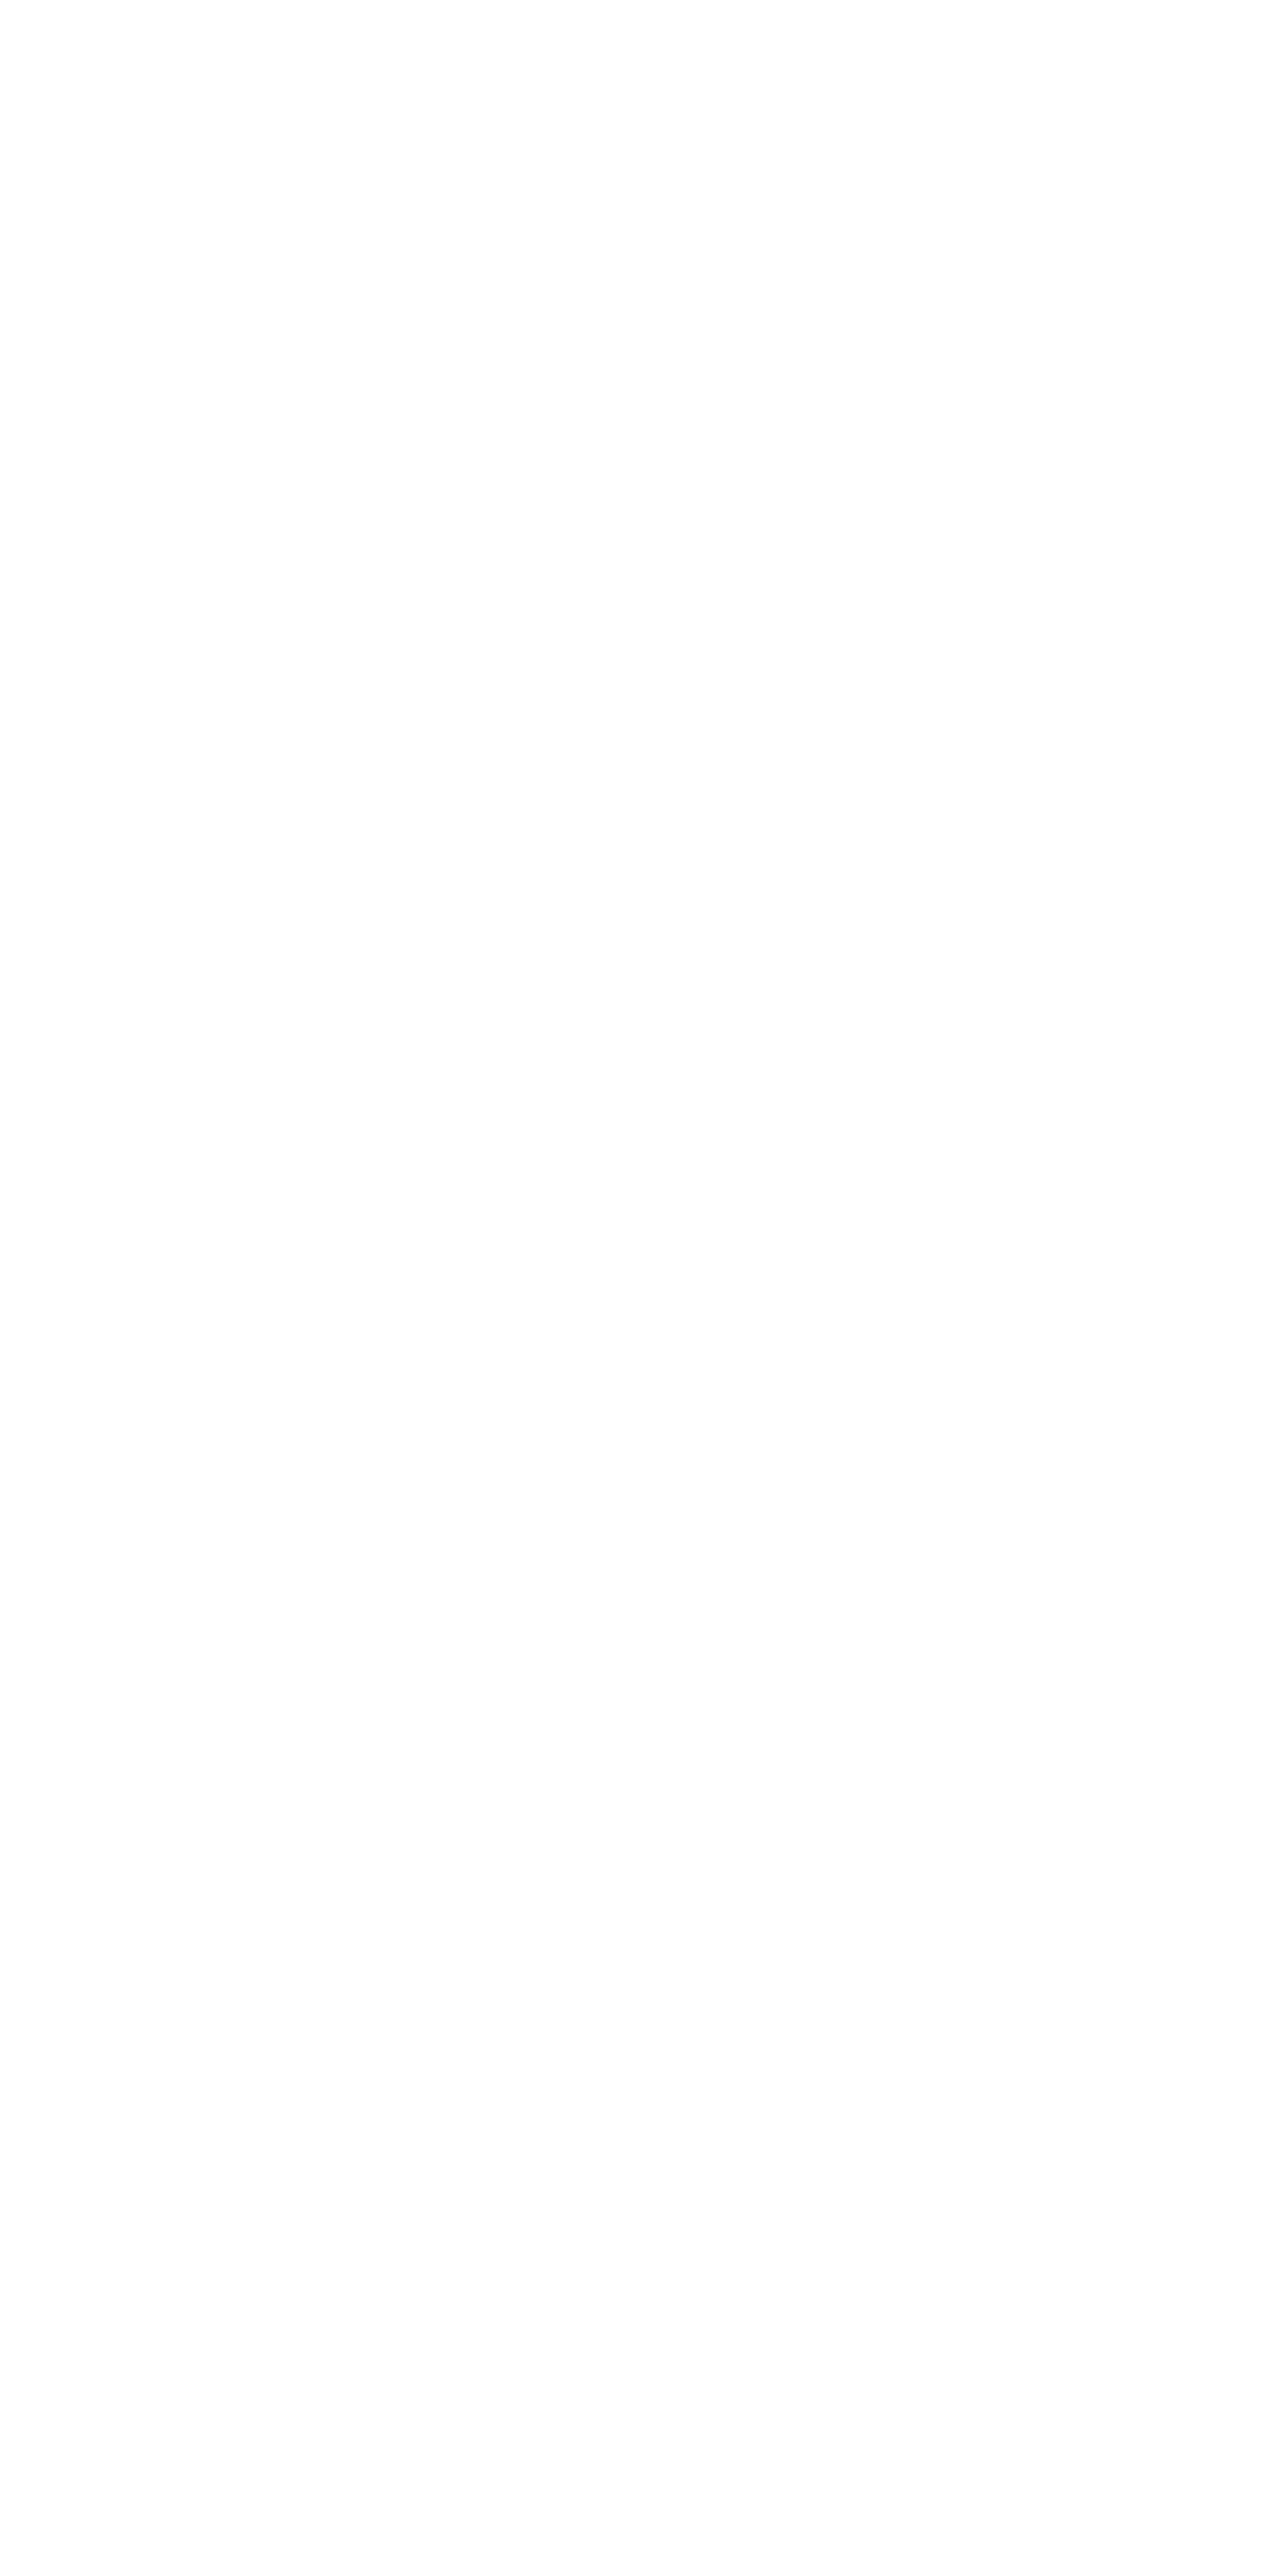

<IPython.core.display.Javascript object>


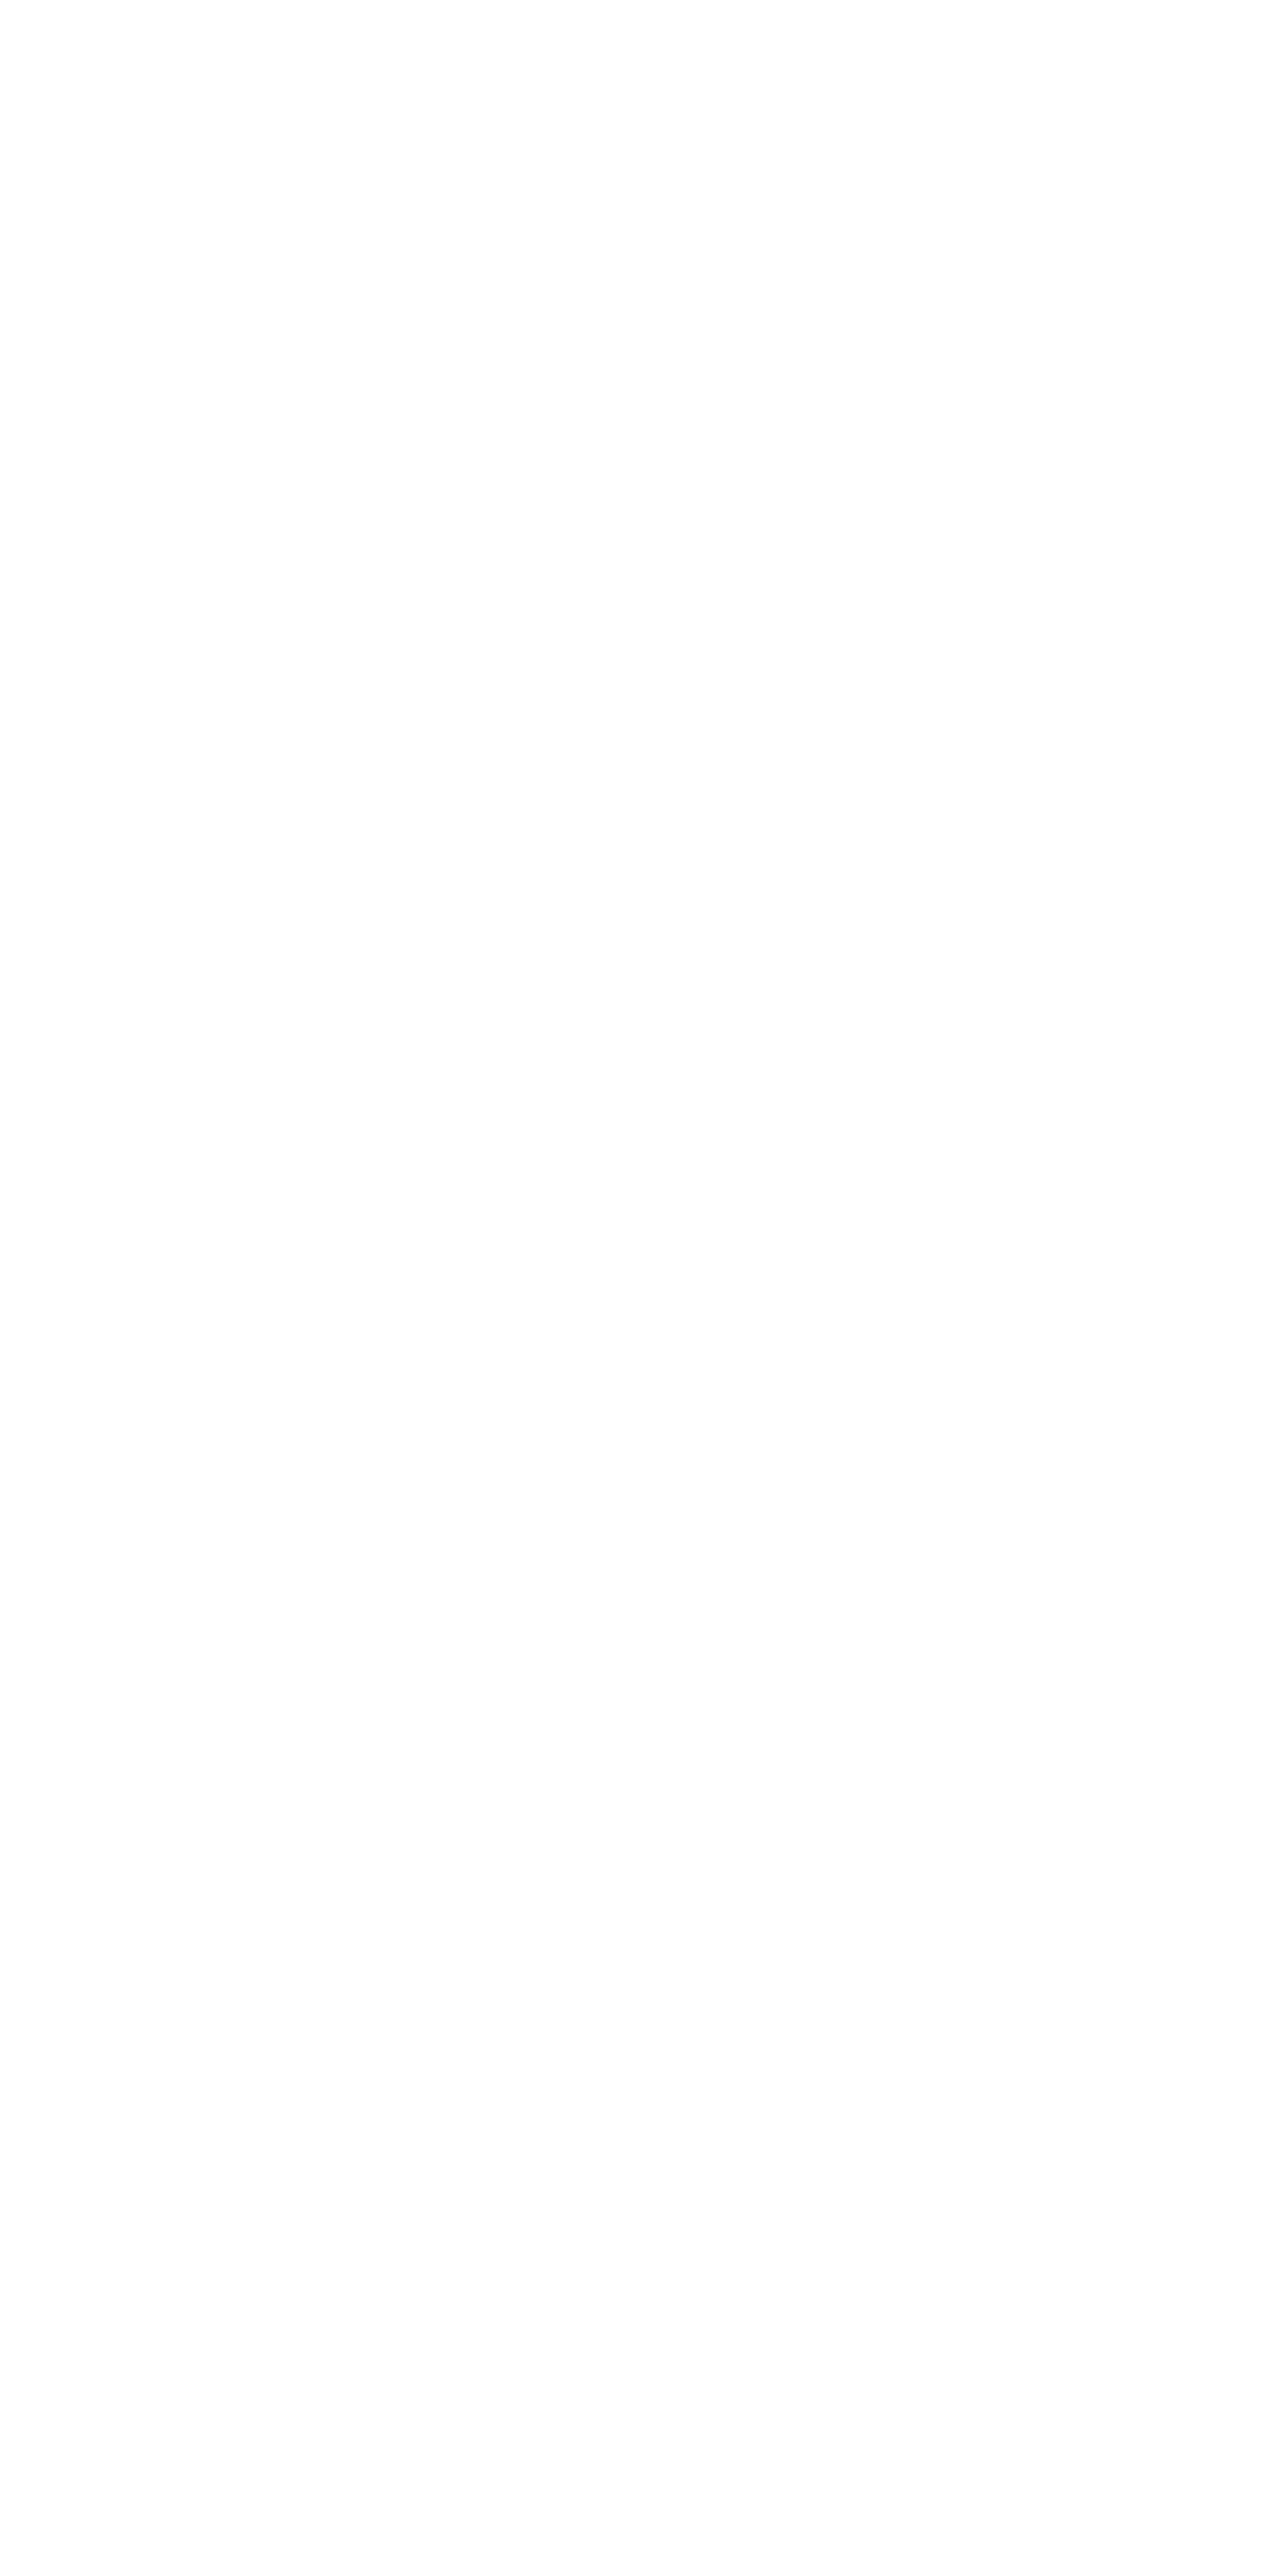

In [21]:
%pylab notebook
def callback(event):
    global x, y
    x, y = int(event.xdata + 0.5), int(event.ydata + 0.5)


time = 0
img_toshowNoMask = three_band_image(masked_cloud,bands = ['red', 'green', 'blue'], time = time)
img_toshow = three_band_image(ds,bands = ['red', 'green', 'blue'], time = time)
fig = plt.figure(1, [10,20])
fig.canvas.mpl_connect('button_press_event', callback)

plt.subplot(211)
ax = plt.gca()
ax.set_title("All Pixels", fontweight = 'bold', fontsize = 16)
ax.set_xticklabels(ds.x.values)
ax.set_yticklabels(ds.y.values)
ax.set_xlabel('Easting', fontweight = 'bold')
ax.set_ylabel('Northing', fontweight = 'bold')
imshow(img_toshow)

plt.subplot(212)
ax = plt.gca()
ax.set_title("Artifacts Filtered Out", fontweight = 'bold', fontsize = 16)
ax.set_xticklabels(ds.x.values)
ax.set_yticklabels(ds.y.values)
ax.set_xlabel('Easting', fontweight = 'bold')
ax.set_ylabel('Northing', fontweight = 'bold')
imshow(img_toshowNoMask)



Next we'll select a single pixel from any of the above images and drill through the time dimension to calculate the change in nDVI.

Before running the below cell click on a location in the above visualisations to select an area to explore through time with a 100x100 lens.

In [22]:
pixelDrillExtent = []
for i in [[x , y], [x + 100, y + 100]]:
    xI,yI = i
    getLong = ds.isel(x=[xI], y=[yI]).isel(time=0).x.values
    getLat = ds.isel(x=[xI], y=[yI]).isel(time=0).y.values
    
    pixelDrillExtent.append(transformToWGS(getLong, getLat,int(EPSG)))
print (pixelDrillExtent)

NameError: name 'x' is not defined

By expanding out the time extent and limiting the x,y extent in the datacube.load() we are able to retrieve cross section through time.


In [23]:
%%time
date_range = (datetime.datetime(2017,3,12),datetime.datetime(2018,3,14))
ds1 = dc.load(product='ls8_level1_usgs', x=(pixelDrillExtent[0][0],pixelDrillExtent[1][0]), y=(pixelDrillExtent[0][1],pixelDrillExtent[1][1]), 
             output_crs = 'epsg:28355', resolution = (-30,30), time = date_range,measurements = ('red','nir','quality'))



CPU times: user 11.7 s, sys: 5.07 s, total: 16.8 s
Wall time: 32min 50s


In [25]:
print (ds1)

<xarray.Dataset>
Dimensions:  (time: 45, x: 101, y: 101)
Coordinates:
  * time     (time) datetime64[ns] 2017-03-12T23:52:26.445797 ...
  * y        (y) float64 5.21e+06 5.21e+06 5.21e+06 5.21e+06 5.21e+06 ...
  * x        (x) float64 4.763e+05 4.763e+05 4.764e+05 4.764e+05 4.764e+05 ...
Data variables:
    red      (time, y, x) int16 6072 6069 6093 6122 6236 6177 6129 6465 6155 ...
    nir      (time, y, x) int16 10081 9960 11089 11307 12592 13433 14687 ...
    quality  (time, y, x) int16 2720 2720 2720 2720 2720 2720 2720 2720 2720 ...
Attributes:
    crs:      epsg:28355


We use band math to derive an nDVI and mask out occluded measurements.

<IPython.core.display.Javascript object>


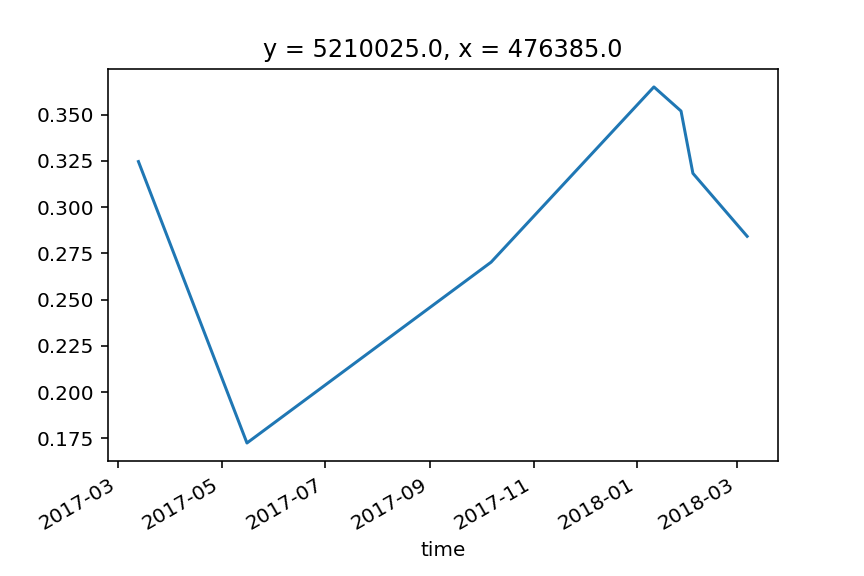

In [26]:
%matplotlib notebook

red = ds1.red.where(ds1.red != ds1.red.attrs['nodata'])
nir = ds1.nir.where(ds1.nir != ds1.nir.attrs['nodata'])

cloud_free = masking.make_mask(ds1.quality,cloud=False, radiometric_saturation = 'none', terrain_occlusion = False)

ndvi = ((nir - red) / (nir + red)).where(cloud_free).dropna('time')
ndvi.isel(x =[3], y=[6]).plot() #Plots the change in nDVI over the time extent using the array index.
#ndvi.isel(x =465105, y=5194065).plot() #Plots the change in nDVI over the time extent using the X and Y coordinate.




Plot out a crossection accross the y axis of an x coordinate over a time extent.

<IPython.core.display.Javascript object>


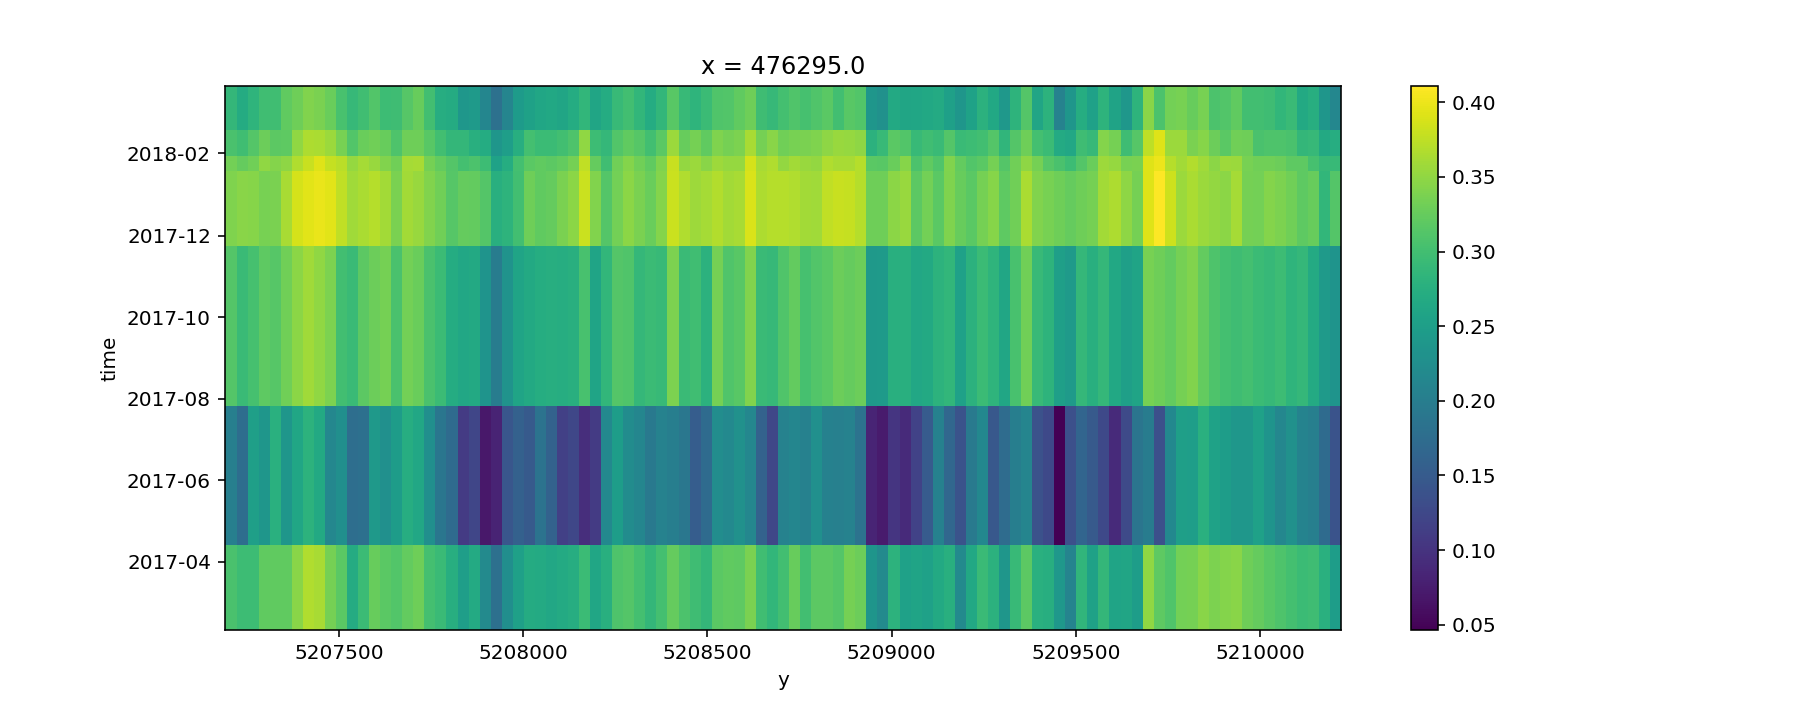

In [28]:
%matplotlib notebook
ndvi.isel(x =[0]).plot()
